## Import modules

In [1]:
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, ReLU, Input, MaxPooling1D
from tensorflow.keras.models import Sequential

import numpy as np

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorf

## LOAD DATABASES, CONCATENATE AND MIX THEM

In [2]:
rv = [35,45,55]
nr = len(rv)



def load_and_shuffle_dbs(rv):
    paths = []
    for r in rv:
        paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")
    
    n_traj = 50000
    db = np.ndarray(shape=(nr*n_traj,2000,1))
    labels = []
    for path,r,i in zip(paths,rv,range(nr)):
        db1 = np.load(path)
        for j in range(n_traj):
            db[i*n_traj + j,:,0] = db1[j,0,:]
            labels.append(r)
    
    labels = np.array(labels)
    
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]
    
    db, labels = unison_shuffled_copies(db, labels)
    return db, labels




#db, labels = load_and_shuffle_dbs(rv)

## CONVERTO LABELS PER DEFINIRE LE CLASSI

In [3]:
lM = 60.
lm = 10.
def norm_labels(labels):
    return (labels - lm)/(lM - lm)

def denorm_labels(labels):
    return labels * (lM - lm) + lm

#labels = norm_labels(labels)

## PREPROCESSING

In [4]:
def preprocess(db):
    db = db[:,:,0:1]
    #print(db.shape)
    M = np.max(db)
    m = np.min(db)
    #print(f'actual max and min: {M:.2f} and {m:.2f}')
    M = 33.45311378674468 # max and min among 10 20 30 40 50 60 databases
    m = -33.45763272036239
    #print(M,m)
    db = (db - m)/(M - m)
    M = np.max(db)
    m = np.min(db)
    #print(M,m)
    return db

#db = preprocess(db)

## VISUALIZE DATA

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

n_traj = 50000
n = round(np.random.uniform(n_traj*nr))
#n = 35368
print(n)
traj = db[n,:,:]
print(labels[n])
plt.plot(traj[:,0])
#plt.plot(traj[:,1])
#plt.plot(traj[:,2])
plt.show()

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot3D(traj[:,0],traj[:,1],traj[:,2])

## ARCHITETTURA RETE NEURALE

In [44]:
opt = Adam(0.00008)#, 0.5)
sig_len, channels = len(db[0,:,0]), len(db[0,0,:])
fs = 20 # dimensione filtro
fm = 8 # numero filtri
sigma_init = 0.02 # varianza distribuzione parametri iniziali dei kernel
mean_init = 0.
def create_desc():
    discriminator = Sequential()
    #2000x1
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(sig_len, channels)))    
    #250x8
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
    #32x8
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init))) 
    #8x8
    discriminator.add(Flatten())
    #64x1
    discriminator.add(Dense(8*fm, activation='relu'))
    #64x1
    discriminator.add(Dense(1, activation='relu'))
    #1x1
    discriminator.compile(loss='mse', optimizer=opt)
    return discriminator

desc = create_desc()

In [45]:
desc.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 250, 8)            168       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 32, 8)             1288      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8, 8)              1288      
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 6,969
Trainable params: 6,969
Non-trainable params: 0
____________________________________________________

# TRAINING

In [ ]:
#desc = create_desc()
fit_history = desc.fit(db, labels, batch_size=256, epochs=70, verbose=1, validation_split=0.33,
                       shuffle=False)#, callbacks=[history])

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  


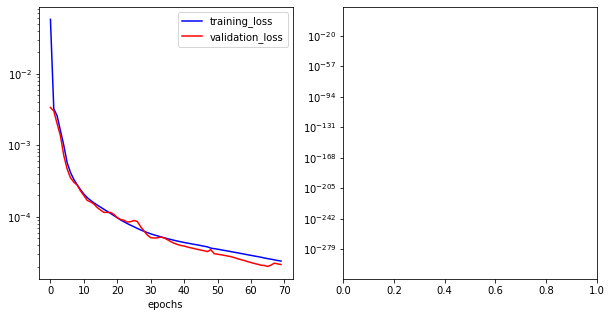

In [50]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
#epoch = fit_history.history
epoch = fit_history.history
ax1.set_xlabel("epochs")
plt.yscale('log')
ax1.plot(epoch['loss'], color="b",label="training_loss")
ax1.plot(epoch['val_loss'], color="r",label="validation_loss")
ax1.set_yscale('log')
ax1.legend()
plt.savefig(f'plots/training_plot_rho{rv}.png', dpi=220, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [5]:
#desc.save('predictor_10_20_30_40_50_60.h5')
from tensorflow.keras.models import load_model
desc = load_model('models/predictor_10_20_30_40_50_60.h5')

W0520 13:45:54.340711 47130581720576 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0520 13:45:54.343082 47130581720576 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0520 13:45:54.448506 47130581720576 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__i

# TESTING

### mean and std plot for every r

In [ ]:
def test_prep(rv):
    db, labels = load_and_shuffle_dbs(rv)
    labels = norm_labels(labels)
    db = preprocess(db)
    return db, labels

rv = [[r] for r in np.arange(10,70,10)]
rr = []
mm = []
ss = []
for r in rv:
#    try:
    db, labels = test_prep(r)
    aaa = desc.predict(db)
    bbb = denorm_labels(aaa)
    
    a = []
    for aa in bbb:
        a.append(aa[0])
    bbb_mean = np.mean(a)
    bbb_std = np.std(a)
    print(f'{r[0]:.1f}   estimated mean: {bbb_mean:.3f}+-{bbb_std:.3f}')
    rr.append(r[0])
    mm.append(bbb_mean)
    ss.append(bbb_std)
#    except: print(f'{r[0]} not present')

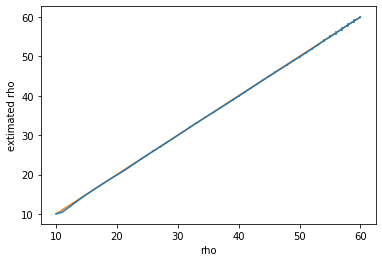

In [70]:
import matplotlib.pyplot as plt

plt.errorbar(rr, mm, ss)
def ff(x): return x
xx = np.arange(10,60,0.3)
plt.plot(xx, ff(xx))
plt.xlabel('rho')
plt.ylabel('extimated rho')
plt.show()

### scatter plot for every r

In [73]:
def test_prep(rv):
    db, labels = load_and_shuffle_dbs(rv)
    labels = norm_labels(labels)
    db = preprocess(db)
    return db, labels

rv = [[r] for r in np.arange(10,61,1)]
rr = []
err = []
for r in rv:
    db, labels = test_prep(r)
    aaa = desc.predict(db)
    bbb = denorm_labels(aaa)
    
    a = []
    for aa in bbb:
        a.append(aa[0])
    for i in range(50000): rr.append(r[0])
    err = err + a
    print(r[0], end=' ')

10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 

In [74]:
rr = []
for r in rv:
    for i in range(50000):
        rr.append(r[0])
rr1 = []
for r in rv:
    rr1.append(r[0])

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


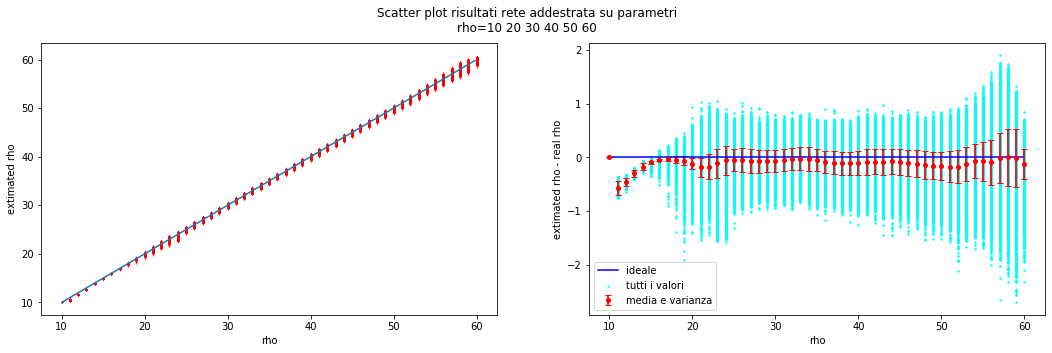

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))
ax1.scatter(rr, err, s=1.7, c='red', marker='o', alpha=0.005)
xx = np.arange(10,60,0.3)
ax1.plot(xx, xx)
ax1.set_xlabel('rho')
ax1.set_ylabel('extimated rho')
# scatter normalized around zero
ax2.scatter(rr, [er-r for er,r in zip(err,rr)], s=2, c='cyan', marker='o', label='tutti i valori')
xx = np.arange(10,60,0.3)
l, caps, c = ax2.errorbar(rr1, mm - np.array(rr1), ss, lw=0, marker='o', ms=4, elinewidth=1.7, uplims=True, lolims=True, c='red', label='media e varianza')
for cap in caps:
    cap.set_marker("_")
ax2.plot(xx, [0.]*len(xx), c='blue', label='ideale')
ax2.set_xlabel('rho')
ax2.set_ylabel('extimated rho - real rho')
ax2.legend(loc="lower left")

fig.suptitle('Scatter plot risultati rete addestrata su parametri\nrho=10 20 30 40 50 60')
fig.savefig(f'plots/scatterplot_predictor.png', dpi=220, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

### plot of pdf for a single value of r

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  


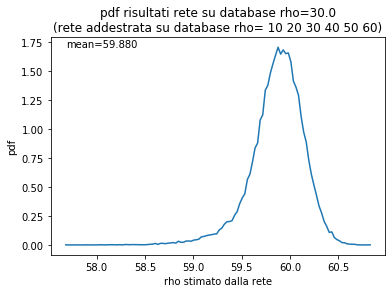

In [76]:
import matplotlib.pyplot as plt
rv = [30.]
nr = len(rv)
if nr == 1 :
    hist, bins = np.histogram(bbb,bins=120, density=True)
    plt.title(f'pdf risultati rete su database rho={rv[0]}\n(rete addestrata su database rho= 10 20 30 40 50 60)')
    plt.xlabel('rho stimato dalla rete')
    plt.ylabel('pdf')
    plt.plot(bins[:-1],hist)
    plt.text(np.min(bins[:-1]),np.max(hist),f'mean={bbb_mean:.3f}')
    plt.savefig(f'plots/pdf_predictor_rho{rv[0]}.png', dpi=220, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)
    plt.show()

# Analisi previsioni del modello con rete neurale

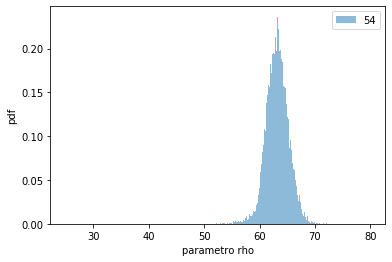

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess(db):
    db = db.reshape(-1,2000,1)
    M = np.max(db)
    m = np.min(db)
    M = 33.45311378674468 # max and min among 10 20 30 40 50 60 databases
    m = -33.45763272036239
    db = (db - m)/(M - m)
    M = np.max(db)
    m = np.min(db)
    return db

rv = [30, 40, 50, 60]
labels = ['r vero = '+str(r) for r in rv]
# paths = [f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy" for r in rv] #### vere
paths = [f"/scratch/scarpolini/lorenz_wgangp_new/runs/3/gen_trajs.npy"] #### generate
for path, label in zip(paths,labels):
    # db = np.load(path)[:,0:1,:] #### vere
    db = np.load(path)[:,:,0:1] #### generate
    # db = preprocess(db) #### vere
    previsione = denorm_labels(desc.predict(db))
    plt.hist(previsione, bins=np.arange(25,80,0.05), density=True, alpha=0.5, label=str(54))

plt.legend()
plt.xlabel('parametro rho')
plt.ylabel('pdf')
plt.legend()
plt.savefig("plots/pdf_NN_predictions_training_rho.png", dpi=220, format='png')
plt.show()

# ANALISI PESI 

In [12]:
a = desc.get_weights()
for i in range(8): 
    print( a[i].shape )

(10, 1, 8)
(8,)
(10, 8, 8)
(8,)
(10, 8, 8)
(8,)
(64, 64)
(64,)


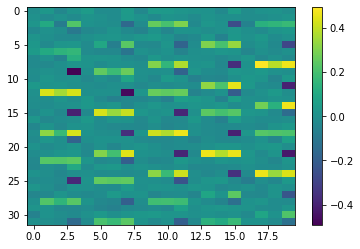

In [18]:
ciccio = a[2].reshape(32,-1)
import matplotlib.pyplot as plt
plt.imshow(ciccio, aspect="auto")
plt.colorbar()